Installation du package pyLDAvis

In [ ]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks/pyldavis', nb_path)
# sys.path.insert(0,nb_path)

Mounted at /content/drive


In [ ]:
# !pip install --target=$nb_path pyldavis

     |████████████████████████████████| 1.7MB 6.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 481kB 39.9MB/s 
     |████████████████████████████████| 23.9MB 1.7MB/s 
     |████████████████████████████████| 27.4MB 146kB/s 
     |████████████████████████████████| 133kB 47.4MB/s 
     |████████████████████████████████| 15.3MB 46.9MB/s 
     |████████████████████████████████| 829kB 38.1MB/s 
     |████████████████████████████████| 307kB 41.6MB/s 
     |████████████████████████████████| 9.9MB 37.1MB/s 
  Using cached https://files.pythonhosted.org/packages/ae/42/2876a3a136f8bfa9bd703518441c8db78ff1eeaddf174baa85c083c1fd15/setuptools-56.0.0-py3-none-any.whl
     |████████████████████████████████| 22.3MB 1.5MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 235kB 42.4MB/s 
    

#Import des modules

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pyldavis/')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

import pickle

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable



# Import de la base de données

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 6/df_clean.csv', sep = ',', error_bad_lines = False, low_memory = True)

In [ ]:
df.shape

(168931, 4)

# Feature Engineering

## Variable Body + Title

In [ ]:
df['Body_Title'] = df['Body_2'] + df['Title_2']

In [ ]:
X = df[['Body_2','Title_2', 'Body_Title']]

In [ ]:
y = df['Tags_2']

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135144, 3), (33787, 3), (135144,), (33787,))

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_train, y_train, test_size = 0.95, random_state = 42)

In [ ]:
X_train_5.shape

(6757, 3)

In [ ]:
# X_train_5.to_csv('X_train_5_LDA.csv', index = False)
# !cp X_train_5_LDA.csv "/content/drive/My Drive/Colab Notebooks/Projet 6/files/LDA/"

#1/ Approche non supervisée :



#-LDA

##Création des corpus et dictionnaires pour la modélisation

In [ ]:
X_train_5 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 6/files/LDA/X_train_5_LDA.csv', sep = ',', error_bad_lines = False, low_memory = True)

In [ ]:
corpus_title = X_train_5.Title_2.apply(lambda x: x.split())
corpus_body = X_train_5.Body_2.apply(lambda x: x.split())
corpus_merged = X_train_5.Body_Title.apply(lambda x: x.split())
text_title = X_train_5.Title_2.apply(lambda x: x.split())
text_body = X_train_5.Body_2.apply(lambda x: x.split())
text_merged = X_train_5.Body_Title.apply(lambda x: x.split())

In [ ]:
%%time
# Create Dictionary
id2word_title = corpora.Dictionary(corpus_title)
id2word_body = corpora.Dictionary(corpus_body)
id2word_merged = corpora.Dictionary(corpus_merged)

# Create Corpus
texts_title = corpus_title
texts_body = corpus_body
texts_merged = corpus_merged

# Term Document Frequency
corpus_title = [id2word_title.doc2bow(text) for text in texts_title]
corpus_body = [id2word_body.doc2bow(text) for text in texts_body]
corpus_merged = [id2word_merged.doc2bow(text) for text in texts_merged]

# View
print(corpus_title[:1], corpus_body[:1], corpus_merged[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1)]] [[(0, 1), (1, 3), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 3), (9, 4), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 3), (21, 4), (22, 2), (23, 1), (24, 1), (25, 2)]] [[(0, 2), (1, 3), (2, 2), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 4), (11, 4), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 3), (22, 5), (23, 3), (24, 1), (25, 1), (26, 2)]]
CPU times: user 890 ms, sys: 15.7 ms, total: 905 ms
Wall time: 899 ms


In [ ]:
[[(id2word_title[id], freq) for id, freq in cp] for cp in corpus_title[:2]]

[[('app', 1),
  ('django', 1),
  ('field', 1),
  ('many', 2),
  ('table', 1),
  ('three', 1)],
 [('chrome', 1),
  ('devtoolsactiveport', 1),
  ('doesnt', 1),
  ('error', 1),
  ('exist', 1),
  ('python', 1),
  ('rasberrypie', 1)]]

##Détermination du meilleur nombre de topics (via le coherence score)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, id2word, limit, start = 2, step = 4):
    coherence_values = []
    model_list = []
    nb_topics = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topics, id2word = id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
        nb_topics.append(num_topics)

    return model_list, coherence_values, nb_topics

In [ ]:
%%time
model_list_title, coherence_values_title, nb_topics = compute_coherence_values(dictionary = id2word_title, corpus = corpus_title, texts = text_title, start = 2, limit = 51, step = 4, id2word = id2word_title)
score_title = pd.DataFrame(list(zip(nb_topics, coherence_values_title)), columns = ['Nb of topics', 'Coherence Score'])
print(score_title.to_string(index = False))

 Nb of topics  Coherence Score
            2         0.254716
            6         0.327479
           10         0.410840
           14         0.455801
           18         0.467207
           22         0.495825
           26         0.503325
           30         0.518068
           34         0.525172
           38         0.529520
           42         0.547862
           46         0.540709
           50         0.549014
CPU times: user 48 s, sys: 1.04 s, total: 49.1 s
Wall time: 47.7 s


In [ ]:
%%time
model_list_body, coherence_values_body, nb_topics = compute_coherence_values(dictionary = id2word_body, corpus = corpus_body, texts = text_body, start = 2, limit = 51, step = 4, id2word = id2word_body)
score_body = pd.DataFrame(list(zip(nb_topics, coherence_values_body)), columns = ['Nb of topics', 'Coherence Score'])
print(score_body.to_string(index = False))

 Nb of topics  Coherence Score
            2         0.531028
            6         0.449495
           10         0.449009
           14         0.456443
           18         0.451757
           22         0.432469
           26         0.432469
           30         0.402734
           34         0.419954
           38         0.414642
           42         0.409962
           46         0.406521
           50         0.402129
CPU times: user 1min 26s, sys: 1.53 s, total: 1min 27s
Wall time: 1min 26s


In [ ]:
%%time
model_list_merged, coherence_values_merged, nb_topics = compute_coherence_values(dictionary = id2word_merged, corpus = corpus_merged, texts = text_merged, start = 2, limit = 51, step = 4, id2word = id2word_merged)
score_merged = pd.DataFrame(list(zip(nb_topics, coherence_values_merged)), columns = ['Nb of topics', 'Coherence Score'])
print(score_merged.to_string(index = False))

 Nb of topics  Coherence Score
            2         0.442685
            6         0.480178
           10         0.461215
           14         0.464700
           18         0.422783
           22         0.424764
           26         0.412756
           30         0.404309
           34         0.403433
           38         0.397884
           42         0.398847
           46         0.401283
           50         0.405257
CPU times: user 1min 33s, sys: 1.74 s, total: 1min 35s
Wall time: 1min 33s


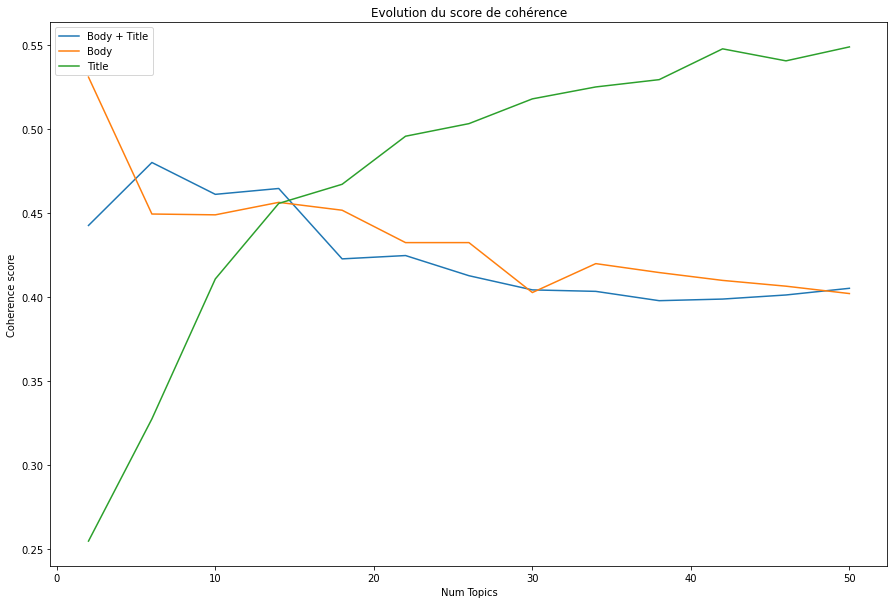

<Figure size 432x288 with 0 Axes>

In [ ]:
limit = 51; start = 2; step = 4;
x = range(start, limit, step)
fig = plt.figure(figsize = (15, 10))
plt.plot(x, coherence_values_merged, label = 'Body + Title')
plt.plot(x, coherence_values_body, label = 'Body')
plt.plot(x, coherence_values_title, label = 'Title')
plt.title('Evolution du score de cohérence')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/Slides/Projet 6/coherence_score.png')

Le meilleur coherence score (0.549014) est obtenu avec la variable 'Title' en utilisant 50 topics

##Optimisation des hyperparamètres

In [ ]:
# Initialisation du modèle avec la variable 'Title'
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = k,
                                           alpha = a,
                                           eta = b)
    
    coherence_model_lda = CoherenceModel(model = lda_model, texts = text_title, dictionary = id2word_title, coherence = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
%%time
# Alpha
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
  for k in [50] :
    for a in alpha:
      for b in beta:
        cv = compute_coherence_values(corpus = corpus_title, dictionary = id2word_title, 
                                                  k = k, a = a, b = b)
        # Sauvegarde des résultats
        model_results['Topics'].append(k)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)

    results_df = pd.DataFrame(model_results)
    pd.DataFrame(model_results).to_csv('lda_title_tuning.csv', index = False)
    !cp lda_title_tuning.csv "/content/drive/My Drive/Colab Notebooks/Projet 6/files/LDA/"

CPU times: user 2min 20s, sys: 3.65 s, total: 2min 23s
Wall time: 2min 18s


In [ ]:
# results_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 6/lda_title_tuning.csv', sep = ',', error_bad_lines = False, low_memory = True)

In [ ]:
results_df.sort_values(by = 'Coherence', ascending = False)

,Topics,Alpha,Beta,Coherence
1,50,0.01,0.31,0.560761
10,50,0.61,0.01,0.560370
15,50,0.91,0.01,0.559906
14,50,0.61,symmetric,0.557705
21,50,symmetric,0.31,0.556696
9,50,0.31,symmetric,0.553878
20,50,symmetric,0.01,0.548920
24,50,symmetric,symmetric,0.544034
19,50,0.91,symmetric,0.540175
4,50,0.01,symmetric,0.539500


In [ ]:
results_df_2 = results_df.round(2)
results_df_2 = results_df_2.replace('symmetric', 1.21)
results_df_2 = results_df_2.replace('asymmetric', 1.51)

In [ ]:
from plotly.figure_factory import create_trisurf
from scipy.spatial import Delaunay

x = results_df_2['Alpha'].to_numpy().flatten()
y = results_df_2['Beta'].to_numpy().flatten()
z = results_df_2['Coherence'].to_numpy().flatten()

points2D = np.vstack([x,y]).T
tri = Delaunay(points2D)


simplices = tri.simplices
fig1 = create_trisurf(x = x, y = y, z = z, colormap = "RdBu",
                      simplices = simplices, title = 'x = Alpha ; y = Beta ; z = Coherence Score')

In [ ]:
fig1

##Création du modèle final

In [ ]:
data_words = X_train_5['Title_2'].apply(lambda x: x.split())
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
%%time
# Réglage des hyperparamètres
num_topics = 50
alpha = 0.01
eta = 0.31
# Setup du modèle
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = num_topics,
                                       alpha = alpha,
                                       eta = eta)

CPU times: user 2.3 s, sys: 0 ns, total: 2.3 s
Wall time: 2.28 s


Score perplexity et coherence

In [ ]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = text_title, dictionary = id2word_title, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.032840550488473

Coherence Score:  0.5437257171189543


##Visualisation des topics

In [ ]:
%%time
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(lda_model, corpus = corpus, dictionary = lda_model.id2word)

CPU times: user 2.14 s, sys: 195 ms, total: 2.33 s
Wall time: 6.13 s


In [ ]:
visual

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.072228 -0.165035       1        1  6.345638
27     0.146874  0.035157       2        1  5.984333
19     0.123485  0.015319       3        1  5.846707
49     0.090234  0.041521       4        1  4.436255
40     0.041610  0.018007       5        1  4.254793
45     0.030030  0.003162       6        1  4.126424
21     0.012602 -0.032437       7        1  3.377381
6      0.007271 -0.018006       8        1  2.674243
38    -0.025578 -0.010662       9        1  2.597923
9      0.003140  0.014407      10        1  2.567082
34     0.002261  0.028995      11        1  2.481296
10    -0.000551 -0.019153      12        1  2.385948
39    -0.000875  0.051757      13        1  2.325241
14    -0.020609 -0.000106      14        1  2.169584
28     0.007734  0.005956      15        1  2.008008
23     0.001389 -0.006072      16        1  1.912490
32     0.007711  0.001913      17        1  1.874007
2     -0.004510  0.035188      18        1  1.869880
29    -0.026424 -0.014227      19        1  1.789443
12    -0.022206  0.008927      20        1  1.683538
3     -0.002775 -0.005080      21        1  1.593380
35    -0.003934  0.000024      22        1  1.569221
1     -0.020713  0.011174      23        1  1.556968
18    -0.033773 -0.004410      24        1  1.549352
16     0.004581  0.002580      25        1  1.546091
25    -0.013010  0.005062      26        1  1.527905
7     -0.023794 -0.002872      27        1  1.472269
42    -0.014790  0.036989      28        1  1.462471
20    -0.025524  0.006094      29        1  1.454622
33    -0.012096  0.001884      30        1  1.450825
31    -0.008930 -0.019075      31        1  1.423127
8     -0.017804 -0.016536      32        1  1.380335
30    -0.007910  0.000343      33        1  1.354846
43    -0.013915  0.000824      34        1  1.310070
13    -0.016111 -0.011957      35        1  1.254114
17     0.000584  0.010101      36        1  1.247252
47    -0.023618 -0.003655      37        1  1.212108
37    -0.012592 -0.005064      38        1  1.191998
0     -0.005322  0.002390      39        1  1.175969
36    -0.029737 -0.009574      40        1  1.167847
41    -0.012861  0.002951      41        1  1.060016
46    -0.026441  0.006568      42        1  1.028041
44    -0.003842  0.014938      43        1  1.026271
15    -0.008279 -0.004580      44        1  0.988321
11    -0.016546 -0.005651      45        1  0.976454
22    -0.020699  0.000147      46        1  0.971946
24    -0.015491 -0.002549      47        1  0.963054
26    -0.028438 -0.009140      48        1  0.896380
4     -0.016905  0.003723      49        1  0.839544
48    -0.015132 -0.000260      50        1  0.638990, topic_info=           Term        Freq       Total Category  logprob  loglift
24            c  254.000000  254.000000  Default  30.0000  30.0000
16        value  199.000000  199.000000  Default  29.0000  29.0000
65   javascript  142.000000  142.000000  Default  28.0000  28.0000
9         error  136.000000  136.000000  Default  27.0000  27.0000
21        array  171.000000  171.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
11       python    0.333548  171.765735  Topic50  -6.3947  -1.1911
120        code    0.282533   64.989612  Topic50  -6.5607  -0.3851
826      thread    0.224668   29.155182  Topic50  -6.7899   0.1873
16        value    0.235963  199.417601  Topic50  -6.7408  -1.6864
152    variable    0.207240  104.435043  Topic50  -6.8706  -1.1694

[2063 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
274      50  0.181824         able
1582     19  0.167012     absolute
4285      6  0.309935  accelerated
1424     11  0.312849       accent
389       4  0.427331       access
...     ...       ...          ...
761      43  0.288585         zero
52       31  0.304291          zip
4401     

#2/ Approche supervisée :

#-Préparation des données

In [ ]:
df['Body_Title'] = df['Body_2'] + df['Title_2']

In [ ]:
X = df[['Body_Title']]

In [ ]:
y = df['Tags_2']
y = y.str.replace("[", "")
y = y.str.replace("]", "")
y = y.str.replace("'", "")

In [ ]:
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y.str.split(', '))

In [ ]:
##Sauvegarde du multilabelbinarizer
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/mlb.pkl','wb') as f:
    pickle.dump(mlb, f)

In [ ]:
list(mlb.classes_)

['.net',
 'algorithm',
 'android',
 'angular',
 'angularjs',
 'apache-spark',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'bash',
 'c',
 'c#',
 'c++',
 'css',
 'dataframe',
 'date',
 'excel',
 'firebase',
 'flask',
 'html',
 'ios',
 'java',
 'javascript',
 'jquery',
 'json',
 'laravel',
 'linux',
 'list',
 'mongodb',
 'mysql',
 'node.js',
 'numpy',
 'pandas',
 'php',
 'python',
 'python-2.7',
 'python-3.x',
 'r',
 'reactjs',
 'regex',
 'rust',
 'selenium',
 'shell',
 'spring',
 'sql',
 'sql-server',
 'string',
 'swift',
 'typescript',
 'windows']

In [ ]:
y_bin.shape

(168931, 50)

##Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.2, train_size = 0.8, random_state = 42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135144, 1), (33787, 1), (135144, 50), (33787, 50))

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_train, y_train, test_size = 0.95, random_state = 42)

In [ ]:
X_train_5.shape, y_train_5.shape

((6757, 1), (6757, 50))

Sauvegarde des Split

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/X_train.pkl','wb') as f:
    pickle.dump(X_train, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/X_test.pkl','wb') as f:
    pickle.dump(X_test, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/y_train.pkl','wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/y_test.pkl','wb') as f:
    pickle.dump(y_test, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/X_train_5.pkl','wb') as f:
    pickle.dump(X_train_5, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/y_train_5.pkl','wb') as f:
    pickle.dump(y_train_5, f)

## TF-IDF sur la variable 'Body_Title'
















In [ ]:
vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df = 10,
                                       max_df = 0.3,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor = None,
                                       token_pattern = r"(?u)\S\S+")
train_tf = vectorizer.fit_transform(X_train_5['Body_Title'])
test_tf = vectorizer.transform(X_test['Body_Title'].values.astype('U'))

In [ ]:
##Sauvegarde du Tf-IDF
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/TF-IDF.pkl','wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
train_tf.shape

(6757, 1510)

In [ ]:
body_title_5_train_df = pd.DataFrame(train_tf.todense(), columns = vectorizer.get_feature_names())

##PCA : Principal Component Analysis

In [ ]:
pca = PCA(.80)
pca.fit(body_title_5_train_df)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
##Sauvegarde du PCA
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/PCA_5.pkl','wb') as f:
    pickle.dump(pca, f)

In [ ]:
body_title_train_5_PCA = pca.transform(body_title_5_train_df)
body_title_train_5_PCA.shape

(6757, 586)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/train_PCA_5.pkl','wb') as f:
    pickle.dump(body_title_train_5_PCA, f)

#-Modélisation

In [ ]:
LR_model = LogisticRegression()
RFC_model = RandomForestClassifier()
XGB_model = xgb.XGBClassifier()

##Optimisation des hyperparamètres

###XGBOOST

In [ ]:
%%time
params = {'estimator__min_child_weight': [2, 4],
        'estimator__gamma': [0.5, 1],
        'estimator__max_depth': [2, 4]
        }

xgb_2 = OneVsRestClassifier(xgb.XGBClassifier())
grid_xgb = GridSearchCV(estimator = xgb_2, param_grid = params, cv = 3)
grid_xgb.fit(title_train_PCA, y_train_5)

CPU times: user 4h 35min 59s, sys: 21.8 s, total: 4h 36min 21s
Wall time: 4h 35min 3s


In [ ]:
grid_xgb.best_score_

0.1667891925955183

In [ ]:
grid_xgb.best_estimator_

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0.5,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=4,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

###RandomForestClassifier

In [ ]:
%%time
rfc_params = {'estimator__n_estimators' : [200],
          'estimator__min_samples_leaf' : [1, 2, 4],
          'estimator__min_samples_split': [2, 4],
          'estimator__max_depth': [2, 5]
          }

rfc_2 = OneVsRestClassifier(RandomForestClassifier())

rfc_clf = RandomizedSearchCV(rfc_2, rfc_params, n_iter = 10, cv = 3, random_state = 1, n_jobs = -1)

randomized_rfc = rfc_clf.fit(title_train_PCA, y_train_5)

CPU times: user 11min 51s, sys: 4.64 s, total: 11min 55s
Wall time: 2h 6min 32s


In [ ]:
randomized_rfc.best_score_

0.012579438191351733

In [ ]:
randomized_rfc.best_estimator_

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=4,
                                                     min_weight_fraction_leaf=0.0,
                                               

###Logistic Regression

In [ ]:
%%time
lr_params = {'estimator__C' : [150, 100, 10],
          'estimator__penalty' : ['l1', 'l2']
          }

lr_2 = OneVsRestClassifier(LogisticRegression())

lr_clf = GridSearchCV(estimator = lr_2, param_grid = lr_params, cv = 3, n_jobs = -1)

grid_lr = lr_clf.fit(title_train_PCA, y_train_5)          

CPU times: user 33 s, sys: 4.67 s, total: 37.6 s
Wall time: 2min 29s


In [ ]:
grid_lr.best_score_

0.2634298929629253

In [ ]:
grid_lr.best_estimator_

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

## Cross-Validation

In [ ]:
XGB_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0.5,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=4,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1)

RFC_model = RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=4,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                     random_state=None,
                                                     verbose=0,
                                                     warm_start=False)

LR_model = LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)

In [ ]:
%%time
results = []
names = []
models = []
models.append(('XGB', OneVsRestClassifier(XGB_model)))
models.append(('RFC', OneVsRestClassifier(RFC_model)))
models.append(('LR', OneVsRestClassifier(LR_model)))
scoring = ['jaccard_weighted', 'f1_weighted']
for name, model in models:
    cv_results = cross_validate(model, body_title_train_PCA, y_train_5, cv = 3,
                           scoring = scoring,
                           return_train_score = True)
    results.append(cv_results)
    names.append(name)
    result_df = pd.DataFrame(results, names)
    for i in result_df.columns :
        if i != 'model':
            result_df[i] = result_df[i].map(lambda x: x.mean())

CPU times: user 1h 2min 26s, sys: 16.4 s, total: 1h 2min 43s
Wall time: 1h 1min 54s


In [ ]:
result_df

,fit_time,score_time,test_jaccard_weighted,train_jaccard_weighted,test_f1_weighted,train_f1_weighted
XGB,778.011412,0.955601,0.235320,0.903163,0.359466,0.946813
RFC,437.786223,2.916130,0.010418,0.040578,0.020071,0.074278
LR,10.483652,0.132749,0.360643,0.536727,0.509109,0.685492


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/cv_df.pkl','wb') as f:
    pickle.dump(result_df, f)

In [21]:
result = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/Train_5/cv_df.pkl'
with open(result, 'rb') as f :
    result_df = pickle.load(f)

In [22]:
result_df.reset_index(inplace = True)

In [23]:
jaccard_df = result_df[['index','test_jaccard_weighted']]
jaccard_df = jaccard_df.rename(columns={'test_jaccard_weighted': 'score'})
jaccard_df['score_name'] = 'Jaccard_Score'

In [26]:
f1_df = result_df[['index','test_f1_weighted']]
f1_df = f1_df.rename(columns={'test_f1_weighted': 'score'})
f1_df['score_name'] = 'F1_score'

In [28]:
 concat_cv = pd.concat([f1_df, jaccard_df])

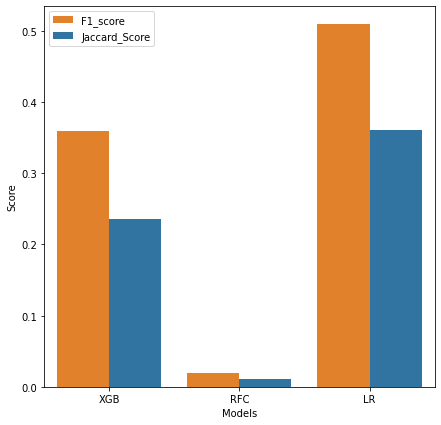

In [66]:
fig = plt.figure(figsize = (7, 7))
ax1 = fig.add_subplot(111)
ax = sns.barplot(y=concat_cv['score'], x=concat_cv['index'], hue=concat_cv['score_name'], palette=['tab:orange','tab:blue'])
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(loc = 'upper left')
ax = plt.xticks()

#-Selection du meilleur modèle : Logistic Regression

##Préparation des données

In [ ]:
X_train = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/X_train.pkl'
with open(X_train, 'rb') as f :
    X_train = pickle.load(f)

In [ ]:
X_test = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/X_test.pkl'
with open(X_test, 'rb') as f :
    X_test = pickle.load(f)

In [ ]:
y_train = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/y_train.pkl'
with open(y_train, 'rb') as f :
    y_train = pickle.load(f)

In [ ]:
y_test = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/y_test.pkl'
with open(y_test, 'rb') as f :
    y_test = pickle.load(f)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135144, 1), (33787, 1), (135144, 50), (33787, 50))

In [ ]:
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(X_train, y_train, test_size = 0.75, random_state = 42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/X_train_25.pkl','wb') as f:
    pickle.dump(X_train_25, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/y_train_25.pkl','wb') as f:
    pickle.dump(y_train_25, f)

In [ ]:
X_train_25.shape, y_train_25.shape

((33786, 1), (33786, 50))

##TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df = 10,
                                       max_df = 0.3,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor = None,
                                       token_pattern = r"(?u)\S\S+")
train_tf = vectorizer.fit_transform(X_train_25['Body_Title'].values.astype('U'))
test_tf = vectorizer.transform(X_test['Body_Title'].values.astype('U'))

In [ ]:
##Sauvegarde du Tf-IDF
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/TF-IDF_25.pkl','wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
train_tf.shape, test_tf.shape

((33786, 3999), (33787, 3999))

In [ ]:
body_title_train_df = pd.DataFrame(train_tf.todense(), columns = vectorizer.get_feature_names())

In [ ]:
body_title_test_df = pd.DataFrame(test_tf.todense(), columns = vectorizer.get_feature_names())

##PCA

In [ ]:
%%time
pca = PCA(.80)
pca.fit(body_title_train_df)

CPU times: user 9min 25s, sys: 3min 58s, total: 13min 24s
Wall time: 24 s


In [ ]:
##Sauvegarde du PCA
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/PCA_25.pkl','wb') as f:
    pickle.dump(pca, f)

In [ ]:
body_title_train_PCA = pca.transform(body_title_train_df)
body_title_train_PCA.shape

(33786, 1125)

In [ ]:
body_title_test_PCA = pca.transform(body_title_test_df)
body_title_test_PCA.shape

(33787, 1125)

##Optimisation du modèle final

In [ ]:
LR_model = LogisticRegression()

In [ ]:
%%time
lr_params = {'estimator__C' : [100, 10, 1.0],
          'estimator__penalty' : ['l1', 'l2']
          }

lr_2 = OneVsRestClassifier(LogisticRegression())

lr_clf = GridSearchCV(estimator = lr_2, param_grid = lr_params, cv = 3, n_jobs = -1)

grid_lr = lr_clf.fit(body_title_train_PCA, y_train_25)          

CPU times: user 30min 54s, sys: 18min 22s, total: 49min 17s
Wall time: 5min 18s


In [ ]:
grid_lr.best_score_

0.3328893624578228

In [ ]:
grid_lr.best_estimator_

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

##Test du modèle sur le jeu de test

In [ ]:
LR_model = LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)

In [ ]:
lr = OneVsRestClassifier(LR_model)

In [ ]:
%%time
lr.fit(body_title_train_PCA, y_train_25)

CPU times: user 30min 37s, sys: 17min 39s, total: 48min 16s
Wall time: 1min 12s


OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
##Sauvegarde du modèle
with open('/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/lr_opti.pkl','wb') as f:
    pickle.dump(lr, f)

In [ ]:
y_pred = lr.predict(body_title_test_PCA)

In [ ]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(jaccard_score(y_test, y_pred, average = 'weighted')))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)))
    print("F1 score : {}".format(f1_score(y_pred, y_test, average = 'weighted')))

In [ ]:
print_score(y_pred, lr)

Clf:  OneVsRestClassifier
Jacard score: 0.44544021614283724
Hamming loss: 0.01941397578950484
F1 score : 0.6336012493390826


In [ ]:
# mlb = '/content/drive/MyDrive/Colab Notebooks/Projet 6/files/Supervised/mlb.pkl'
# with open(mlb, 'rb') as f :
#     mlb = pickle.load(f)

In [ ]:
mlb.inverse_transform(y_pred)

[('bash', 'linux', 'shell'),
 ('c++',),
 ('java',),
 (),
 ('arrays',),
 ('java',),
 (),
 (),
 ('android', 'firebase', 'ios'),
 ('r',),
 ('java',),
 (),
 (),
 ('java',),
 ('python',),
 ('python',),
 ('c++',),
 ('java',),
 (),
 ('html',),
 ('r',),
 ('java',),
 ('python',),
 (),
 ('html', 'javascript'),
 (),
 (),
 ('c#',),
 ('python',),
 ('bash',),
 ('numpy', 'python'),
 ('java',),
 ('pandas', 'python'),
 ('python',),
 ('python',),
 ('java',),
 ('css', 'html'),
 ('java',),
 ('html',),
 (),
 ('php',),
 ('python',),
 ('android', 'java'),
 ('python',),
 ('css', 'html', 'javascript'),
 (),
 ('python',),
 ('arrays', 'numpy', 'python'),
 (),
 (),
 ('pandas', 'python'),
 ('c++',),
 ('javascript',),
 ('javascript', 'jquery'),
 ('r',),
 ('linux',),
 (),
 (),
 (),
 ('android',),
 ('c#',),
 ('css', 'html'),
 ('android', 'java'),
 ('javascript', 'mysql', 'node.js'),
 (),
 (),
 ('mongodb',),
 ('mysql', 'php'),
 ('c++',),
 ('swift',),
 ('angular', 'asp.net-mvc'),
 ('arrays',),
 ('c#',),
 (),
 ('python'

#3/ Approche semi-supervisée :

##Préparation des données

In [ ]:
 #train
all_topics_train = lda_model.get_document_topics(corpus)
all_topics_csr_train = gensim.matutils.corpus2csc(all_topics_train)
all_topics_numpy_train = all_topics_csr_train.T.toarray()

In [ ]:
X_train_lda = all_topics_numpy_train

In [ ]:
 #test
data_words_test = X_test['Title_2'].apply(lambda x: x.split())
id2word_test = corpora.Dictionary(data_words_test)
texts_test = data_words_test
corpus_test = [id2word.doc2bow(text) for text in texts_test]
all_topics_test = lda_model.get_document_topics(corpus_test)
all_topics_csr_test = gensim.matutils.corpus2csc(all_topics_test)
all_topics_numpy_test = all_topics_csr_test.T.toarray()

In [ ]:
X_test_lda = all_topics_numpy_test

In [ ]:
y_test_lda = y_test

##Préparation du modèle

In [ ]:
LR_model = LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)

In [ ]:
lr = OneVsRestClassifier(LR_model)

In [ ]:
%%time
lr.fit(X_train_lda, y_train_5)

CPU times: user 2min 13s, sys: 12min 18s, total: 14min 31s
Wall time: 21.9 s


OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

##Evaluation du modèle

In [ ]:
y_pred_lda = lr.predict(X_test_lda)

In [ ]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(jaccard_score(y_test_lda, y_pred_lda, average = 'weighted')))
    print("Hamming loss: {}".format(hamming_loss(y_pred_lda, y_test_lda)))
    print("F1 score : {}".format(f1_score(y_pred_lda, y_test_lda, average = 'weighted')))

In [ ]:
print_score(y_pred_lda, lr)

Clf:  OneVsRestClassifier
Jacard score: 0.04599711422233924
Hamming loss: 0.8650664456743719
F1 score : 0.18654858472534885


Comparaison entre modèle supervisé et non supervisé

Modèle supervisé

In [41]:
lr_supervised_score = {'Jacard score': 0.44544021614283724,
'Hamming loss': 0.01941397578950484,
'F1 score' : 0.6336012493390826}

In [42]:
lr_supervised_score_df = pd.DataFrame.from_dict(lr_supervised_score,orient='index')
lr_supervised_score_df = lr_supervised_score_df.rename(columns={0: 'score'})
lr_supervised_score_df['score_name'] = 'Supervised'

Modèle semi-supervisé

In [47]:
lr_semi_score = {'Jacard score': 0.04599711422233924,
'Hamming loss': 0.8650664456743719,
'F1 score' : 0.18654858472534885}

In [60]:
lr_semi_score_df = pd.DataFrame.from_dict(lr_semi_score,orient='index')
lr_semi_score_df = lr_semi_score_df.rename(columns={0: 'score'})
lr_semi_score_df['score_name'] = 'semi-supervised'

Comparaison

In [61]:
 concat_test = pd.concat([lr_semi_score_df, lr_supervised_score_df])

In [62]:
concat_test.reset_index(inplace=True)

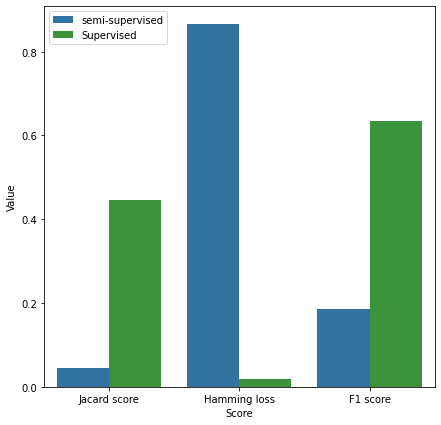

In [64]:
fig = plt.figure(figsize = (7, 7))
ax1 = fig.add_subplot(111)
ax = sns.barplot(y=concat_test['score'], x=concat_test['index'], hue=concat_test['score_name'], palette=['tab:blue','tab:green'])
plt.xlabel('Score')
plt.ylabel('Value')
plt.legend(loc = 'upper left')
ax = plt.xticks()